# Frank Wolfe and Randomized Frank Wolfe for Latent Group Lasso problem

In [1]:
import numpy as np
import pylab as plt
import random
import time

### Creation of the synthetic dataset

In [2]:
def generate_data(n, d, size, overlap):
    """
    Input:
    n       : number of sample
    d       : number of variables
    size    : group size
    overlap : size of the overlap
    """
    np.random.seed(1)
    G=[]
    number_of_groups=int((d-size)/float((size-overlap)))
    
    # list of indices created by taking into account the overlap between consecutive groups
    for i in range(number_of_groups+1):
        G.append(np.arange((size-overlap)*i,(size-overlap)*i+size))
        
    # percentage of coefficients that will appear in the optimal solution
    g_t = int(d*0.01)
    w0_index = random.sample(range(len(G)), g_t)
    g_0 = np.zeros(d)
    
    for i in range(len(w0_index)):
        gt_weight_values = np.random.normal(0, 1, size)
        g_0[G[w0_index[i]]] = g_0[G[w0_index[i]]] + gt_weight_values
       
    # Finally generate the dataset in the classical way
    A = np.random.normal(0,1,(n,d))
    noise = 0.1*np.random.rand(n)
    b = A.dot(g_0) + noise 
    
    return (G, A, b, w0_index)

In [3]:
d = 1000
n = 10000
G, A, b, w_gt = generate_data(n, d, size = 10, overlap = 3)

In [4]:
def e(i, d):
    ei = np.zeros(d)
    ei[i] = 1
    return ei

def gradient_computation(A, b, x_t):
    Ax = A.dot(x_t)
    grad = A.T.dot(Ax - b)
    return grad 

## Frank Wolfe

### Linear minimization oracle 

In [5]:
def linear_oracle(A, b, G, x_t, alpha):
    """
    Input:
    A       : data matrix
    b       : target values
    G       : group index
    x_t     : vector at current iteration
    alpha   : radius of the hyperdisk
    """
    
    gradient = gradient_computation(A, b, x_t)
    gradient_groups=[]
    
    # norm 2 of gradient in each group
    for i in range(len(G)):
        gradient_group_i = np.sqrt(np.sum(np.power(gradient[G[i]],2)))
        gradient_groups.append(float(gradient_group_i))
        
    # find the group with the maximimum l2-norm
    max_index = np.argmax(gradient_groups)
    max_group = G[max_index]
    
    #s_t
    s_t = np.zeros(d)
    s_t[max_group] = - alpha * gradient[max_group] / float(gradient_groups[max_index])
    
    return s_t, gradient

In [6]:
def LGL(A, b, G, alpha, T, tol):
    """
    Input:
    A       : data matrix
    b       : target values
    G       : group index
    alpha   : radius of the hyperdisk
    T       : number of performed iterations
    tol     : tolerance
    """
    np.random.seed(13)
    gap_values=[]
    time_ = []
    time_lmo = []
    
    # starting value
    x_t = np.random.rand(d)
    x_t = x_t * 0.01
    t0 = time.time()
    for it in range(1, T+1):
        
        # LMO
        t2= time.time()
        s_t, gradient = linear_oracle(A, b, G, x_t, alpha)
        t1 = time.time()
        time_lmo.append(t1-t2)
        
        # direction
        d_t = s_t - x_t
        
        # dual gap
        gap = - d_t.T.dot(gradient)
        
        # exact line search for the stepsize
        Ax = A.dot(x_t)
        q_t = A.dot(d_t)
        step_size = q_t.dot(b - Ax) / (q_t.dot(q_t))
        
        # update the value x_t
        x_t = x_t + float(step_size) * d_t
        
        # stopping rule
        if gap <= tol:
            print("FW ended due to duality gap equal to ", gap)
            break
        gap_values.append(float(gap))
        
        time_.append(t1 - t0)
        
    return gap_values, time_, time_lmo

## Randomized Frank Wolfe 

### Randomized linear minimization oracle with continuous slicing

In [7]:
def RLMO_cs(A, b, G, x_t, alpha, eta):
    """
    Input:
    A       : data matrix
    b       : target values
    G       : group index
    x_t     : vector at current iteration
    alpha   : radius of the hyperdisk
    eta     : sampling parameter
    """
    gradient_groups =[]
    gradient = gradient_computation(A, b, x_t)
    gradient_old = gradient.copy()
    number_of_groups = len(G)
    initial_point = np.random.randint(0, number_of_groups)
    subset = (initial_point, min(initial_point + int(eta*number_of_groups) , number_of_groups))
    
    # norm 2 of gradient in each group and sampling groups
    gradient_groups=[]
    for i in range(number_of_groups):
        gradient_group_i = np.sqrt(np.sum(np.power(gradient[G[i]],2)))
        gradient_groups.append(gradient_group_i)
    gradient_groups_sub = gradient_groups[subset[0]:subset[1]]
    
    # find the group with the maximimum l2-norm
    max_index = np.argmax(gradient_groups_sub)
    max_group = G[initial_point + max_index]
    
    # s_t
    s_t = np.zeros(d)
    s_t[max_group]= -alpha * gradient[max_group] / float(gradient_groups_sub[int(max_index)])
    
    # Nbr coefficients of grad
    subset_index = range(initial_point, min(initial_point +int(eta*number_of_groups), number_of_groups))
    number_of_coefficients = len(range(G[subset_index[0]][0], G[subset_index[-1]][-1]+1))
   
    return s_t, number_of_coefficients, gradient

## Randomized Frank Wolfe for Latent Group Lasso - continuous slicing

In [8]:
def LGL_random_cs(A, b, G, alpha, T, tol):
    """
    Input:
    A       : data matrix
    b       : target values
    G       : group index
    alpha   : radius of the hyperdisk
    T       : number of performed iterations
    tol     : tolerance
    """
    np.random.seed(23)
    gap_values=[]
    dual_gap_random =[]
    time_ = []
    nbr =[]
    time_lmo = []
    
    # starting value
    x_t = np.random.rand(d)
    x_t = x_t * 0.01
    t0 = time.time()
    for it in range(1, T+1):
         
        #randomized LMO
        t2 = time.time()
        s_t, number_of_coefficient, gradient = RLMO_cs(A, b, G, x_t, alpha, eta)
        t1 = time.time()
        time_lmo.append(t1-t2)
        
        #direction
        d_t = s_t - x_t
       
        #deterministic LMO
        s_t_det, gradient_old = linear_oracle(A, b, G, x_t, alpha)
        d_t_det = s_t_det - x_t
        
        #stepsize
        Ax = A.dot(x_t)
        q_t = A.dot(d_t)
        step_size = q_t.dot(b - Ax) / (q_t.dot(q_t))
        
        # dual gap
        gap = - d_t_det.T.dot(gradient)
        
        # stopping rule
        if gap <= tol:
            print("FW ended due to duality gap equal to ", gap)
            break
        gap_values.append(float(gap))
        
        # update the vector x_t
        x_t = x_t + step_size * d_t
        
        time_.append(t1 - t0)
        nbr.append(number_of_coefficient)
        
    return gap_values, time_, nbr, time_lmo

## Randomized linear minimization oracle with non-continuous slicing

In [9]:
def RLMO_ncs(A, b, G, x_t, alpha, eta):
    """
    Input:
    A       : data matrix
    b       : target values
    G       : group index
    x_t     : vector at current iteration
    alpha   : radius of the hyperdisk
    eta     : sampling parameter
    """
   
    gradient = gradient_computation(A, b, x_t)
    number_of_groups = len(G)
    length = int(eta*number_of_groups)
    
    # norm 2 of gradient in each group
    gradient_groups=[]
    for i in range(number_of_groups):
        gradient_group_i = np.sqrt(np.sum(np.power(gradient[G[i]],2)))
        gradient_groups.append(gradient_group_i)
    
    # sampling groups
    At = random.sample(range(number_of_groups), number_of_groups - length)
    gradient_groups_sub = np.array(gradient_groups.copy())
    gradient_groups_sub[At] = 0
    
    # find the group with the maximimum l2-norm
    max_index = np.argmax(gradient_groups_sub)
    max_group = G[max_index]
    
    # s_t
    s_t = np.zeros(d)
    s_t[max_group]= -alpha * gradient[max_group] / float(gradient_groups[int(max_index)])
    
    # Nbr coefficients of grad
    number_of_coefficients = d*eta
    
    return s_t, number_of_coefficients, gradient

## Randomized Frank Wolfe for Latent Group Lasso - non-continuous slicing

In [10]:
def LGL_random_ncs(A, b, G, alpha, T, tol):
    """
    Input:
    A       : data matrix
    b       : target values
    G       : group index
    alpha   : radius of the hyperdisk
    T       : number of performed iterations
    tol     : tolerance
    """
    np.random.seed(23)
    gap_values=[]
    dual_gap_random =[]
    time_ = []
    nbr = []
    time_lmo = []
    
    # starting value
    x_t = np.random.rand(d)
    x_t = x_t * 0.01
    t0 = time.time()
    for it in range(1, T+1):
         
        # randomized LMO
        t2 = time.time()
        s_t, number_of_coefficient, gradient = RLMO_ncs(A, b, G, x_t, alpha, eta)
        t1 = time.time()
        time_lmo.append(t1-t2)
        
        # direction
        d_t = s_t - x_t
        
        # deterministic LMO
        s_t_det, gradient2 = linear_oracle(A, b, G, x_t, alpha)
        d_t_det = s_t_det - x_t
        
        # exact line search for the stepsize
        Ax = A.dot(x_t)
        q_t = A.dot(d_t)
        step_size = q_t.dot(b - Ax) / (q_t.dot(q_t))
        
        # dual gap
        gap = - d_t_det.T.dot(gradient)
        
        # stopping rule
        if gap <= tol:
            print("FW ended due to duality gap equal to ", gap)
            break
        gap_values.append(float(gap))
        
        # update the vector x_t
        x_t = x_t + step_size * d_t
        
        time_.append(t1 - t0)
        nbr.append(number_of_coefficient)
        
    return gap_values, time_, nbr , time_lmo

### Experiments

In [11]:
alpha = 20
T = 500
tol = 1e-3
eta = 0.05
(n,d) = np.shape(A)

In [12]:
# Frank Wolfe
gap_values_det, array_time_det, time_lmo_det = LGL(A, b, G, alpha,T, tol)

In [13]:
# Randomized Frank Wolfe with continuous slicing 
gap_values_cs, array_time_cs, nbr_coeff_cs, time_lmo_cs = LGL_random_cs(A, b, G, alpha, T, tol)

In [14]:
# Randomized Frank Wolfe with non-continuous slicing 
gap_values_ncs, array_time_ncs, nbr_coeff_ncs, time_lmo_ncs = LGL_random_ncs(A, b, G, alpha, T, tol)

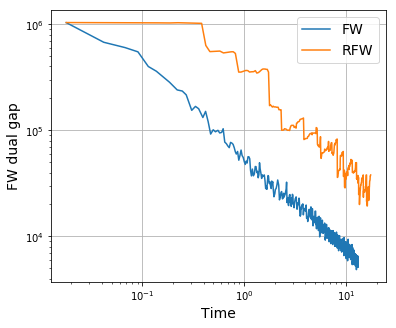

In [15]:
# gap comparison FW vs RFW with continous slicing
fig = plt.figure(figsize=(6,5)) 
ax1 = fig.add_subplot(1, 1, 1) 
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.plot(array_time_det,gap_values_det)
ax1.plot(array_time_cs,gap_values_cs)
plt.xlabel("Time", fontsize = 14)
plt.ylabel("FW dual gap", fontsize = 14)
plt.legend(["FW", "RFW"],fontsize = 14)
plt.grid()
plt.show()

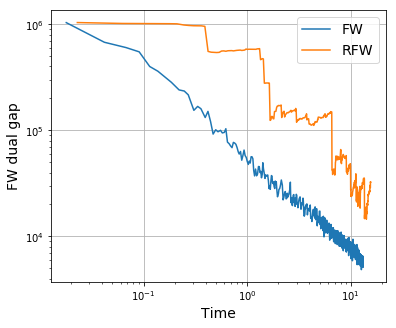

In [16]:
# gap comparison FW vs RFW with non-continous slicing
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_yscale("log")
ax.set_xscale("log")
ax.plot(array_time_det,gap_values_det)
ax.plot(array_time_ncs,gap_values_ncs)
plt.xlabel("Time", fontsize = 14)
plt.ylabel("FW dual gap", fontsize = 14)
plt.legend(["FW", "RFW"],fontsize = 14)
plt.grid()
plt.show()

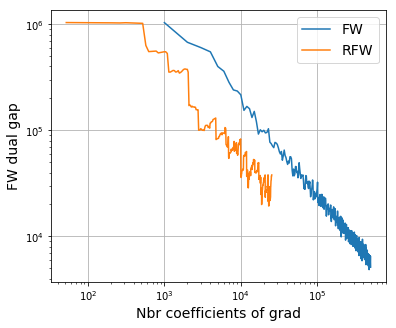

In [17]:
# progress of the gap versus the cumulative number of computed coefficients of gradient per call to LMO, continuos slicing case
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_yscale("log")
ax.set_xscale("log")
ax.plot(np.cumsum(np.ones(T)*d), gap_values_det)
ax.plot(np.cumsum(nbr_coeff_cs), gap_values_cs)
plt.xlabel("Nbr coefficients of grad", fontsize = 14)
plt.ylabel("FW dual gap", fontsize = 14)
plt.legend(["FW", "RFW"],fontsize = 14)
plt.grid()
plt.show()

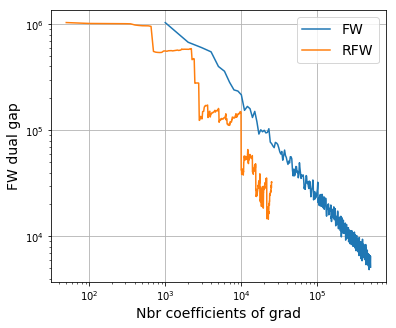

In [18]:
# progress of the gap versus the cumulative number of computed coefficients of gradient per call to LMO, non-continuos slicing case
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_yscale("log")
ax.set_xscale("log")
ax.plot(np.cumsum(np.ones(T)*d), gap_values_det)
ax.plot(np.cumsum(nbr_coeff_ncs), gap_values_ncs)
plt.xlabel("Nbr coefficients of grad", fontsize = 14)
plt.ylabel("FW dual gap", fontsize = 14)
plt.legend(["FW", "RFW"], fontsize = 14)
plt.grid()
plt.show()

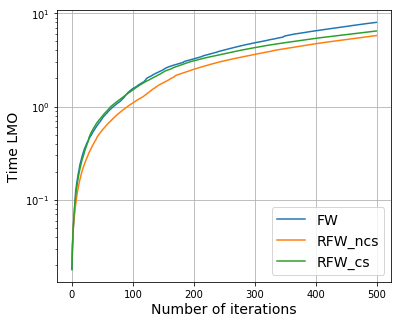

In [19]:
# LMO time comparison for the three algorithms
fig = plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(1, 1, 1) 
ax.set_yscale("log")
ax.plot(np.cumsum(time_lmo_det))
ax.plot(np.cumsum(time_lmo_ncs))
ax.plot(np.cumsum(time_lmo_cs))
plt.xlabel("Number of iterations", fontsize = 14)
plt.ylabel("Time LMO", fontsize = 14)
plt.legend(["FW","RFW_ncs", "RFW_cs"],fontsize = 14)
plt.grid()
plt.show()